In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as wgs
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PolynomialFeatures 
wgs.filterwarnings('ignore')


In [3]:
url=urlopen("https://www.insee.fr/fr/statistiques/6436488#tableau-petrole-g1-fr")

In [4]:
REG=bs(url,'html')
print(REG.prettify())

<!DOCTYPE html>
<html lang="fr">
 <head>
  <title>
   En mars 2022, les prix du pétrole et des matières premières importées accélèrent fortement - Informations rapides - 105 | Insee
  </title>
  <meta content="En mars 2022, le prix du pétrole en euros accélère vivement (+24,7 % après +11,6 % en février). Les prix en euros des matières premières importées (hors énergie) accélèrent fortement eux aussi" name="description"/>
  <link href="


/static/css/application.css
" rel="stylesheet" type="text/css"/>
  <link href="


/static/css/featherlight/featherlight.css
" rel="stylesheet" type="text/css"/>
  <link href="


/static/css/swiper/swiper.min.css
" rel="stylesheet" type="text/css"/>
  <link href="


/static/css/dateTimePicker/jquery.datetimepicker.css
" rel="stylesheet" type="text/css"/>
  <script type="text/javascript">
   var contextPath="";
	var langue="fr";
	var numOnglet="1";
  </script>
  <script charset="UTF-8" src="


/static/js/svg/graphsvg.js
" type="text/javascript">
  </scri

In [5]:
h=REG.find('thead')
Titre=h.text.strip().split('\n')
title=[]
title.append('Date')
title.append(Titre[0])
title.append(Titre[1])
title

['Date', 'Prix en devises', 'Prix en euros']

In [6]:
t=REG.find_all('tbody')
M=[]
for j in t[1]:
    M.append(j.text.strip().split('\n'))


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
D=pd.DataFrame(M)
D.dropna(inplace=True)
D.columns=title
data=D.copy()
data['Date']=D['Date'].astype('datetime64')
data[title[1:]]=D[title[1:]].astype(float)
data.sort_index(ascending=False,inplace=True)
data.set_index('Date',inplace=True)
data.to_csv("importation_petrole.csv")


In [8]:
# Moyenne fixe sur les périodes antérieures
data["Prix en euros"].mean()

57.218018018018014

In [9]:
data

,Prix en devises,Prix en euros
Date,,
2013-01-01,112.0,84.3
2013-02-01,116.4,87.1
2013-03-01,109.7,84.6
2013-04-01,103.8,79.5
2013-05-01,103.0,79.4
...,...,...
2021-11-01,81.0,71.0
2021-12-01,74.4,65.8
2022-01-01,86.5,76.5


<AxesSubplot:xlabel='Prix en euros'>

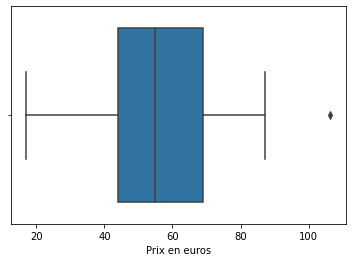

In [10]:
# Boxplot
sns.boxplot(x=data["Prix en euros"])

On retrouve bien une moyenne d'environ 57.21 euros du prix du Brente de petrole aucours de Janvier 2013 à Mars 2022 

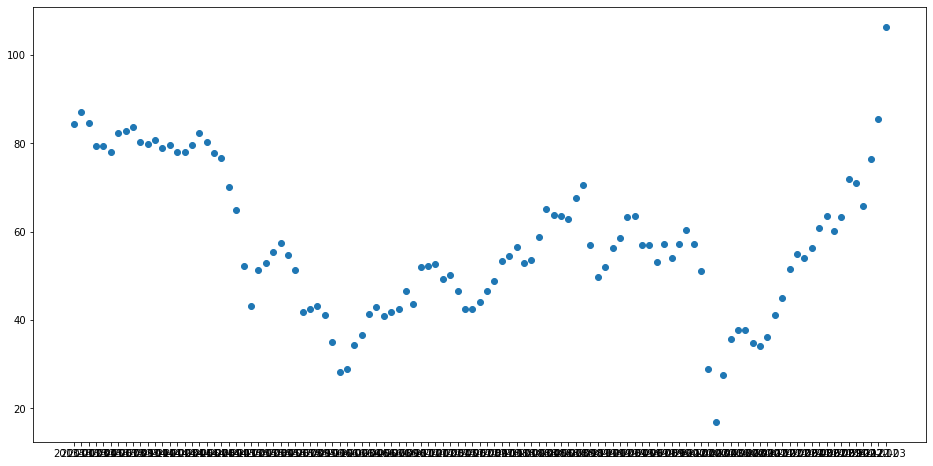

In [11]:
##### Nuage de points
plt.figure(figsize=(16,8))
plt.scatter(x=D["Date"].sort_index(ascending=False),y=data["Prix en euros"].sort_index(ascending=True))


<AxesSubplot:xlabel='Prix en euros', ylabel='Count'>

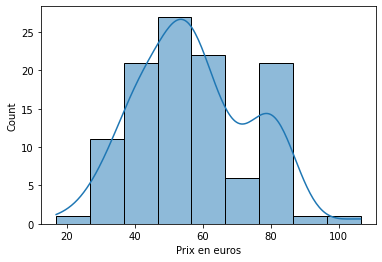

In [12]:
# Histogramme
sns.histplot(data["Prix en euros"],kde=True)

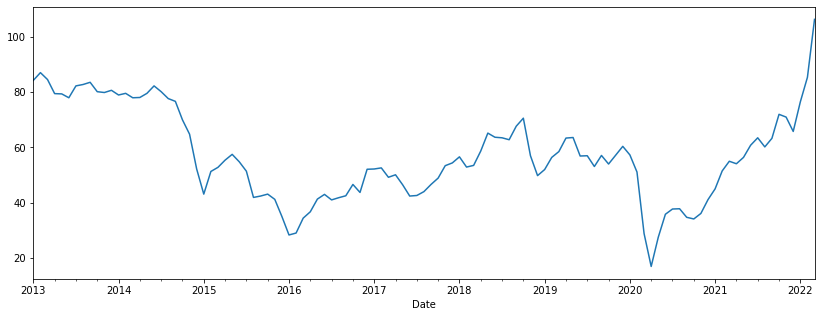

In [13]:
# Prix du pétrole en euro
data["Prix en euros"].plot(figsize=(14,5))
data.sort_index(ascending=False,inplace=True)


In [14]:
#Fonction permettant d'éxécuter les deux test
def get_stationarity(timeseries):
    
    #Statistiques mobiles 
    # calculer la moyenne roulante pour notre df
    rolling_mean = timeseries.rolling(window = 4).mean()
    # calculer l'Ecart-type roulant pour notre df
    rolling_std = timeseries.rolling(window = 4).std()

    # Visulaiser les statistiques mobiles
    plt.plot(timeseries, color='blue', label= 'Origine')
    plt.plot(rolling_mean, color='red', label ='Moyenne mobile')
    plt.plot(rolling_std, color='black', label ='Ecart-type mobile')

    plt.legend(loc='best')
    plt.title('Statistiques roulantes')
    plt.show(block= False)
    
    # Test Dickey-Fuller
    result = adfuller(timeseries,autolag='AIC')
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

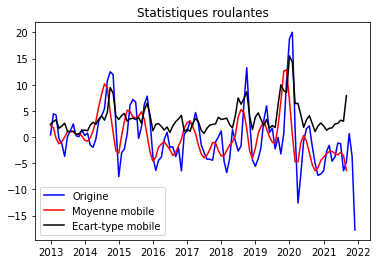

Statistiques ADF : -7.343012863520702
p-value : 1.0530913362567092e-10
Valeurs Critiques :
	1%: -3.4936021509366793
	5%: -2.8892174239808703
	10%: -2.58153320754717


In [15]:
r=data['Prix en euros']-data['Prix en euros'].rolling(window=4).mean()
r.dropna(inplace=True)
get_stationarity(r)
    

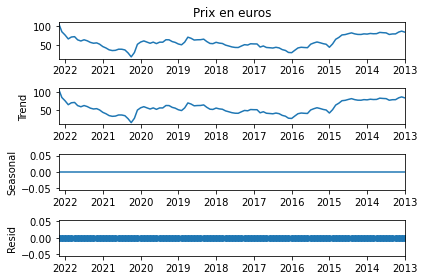

In [16]:
# Décomposition Erreur-saisonnalité-Tendance
seasonal_decompose(data["Prix en euros"], model='additive', freq=1).plot();

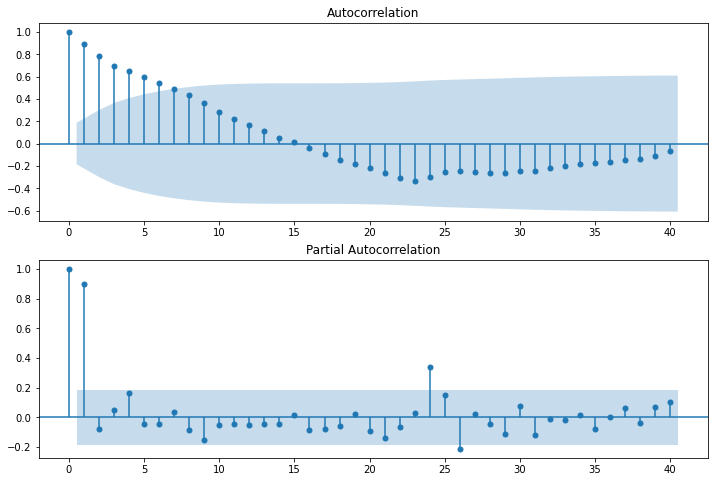

In [17]:

iport matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Prix en euros'], lags=40, ax=ax1,)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Prix en euros'], lags=40, ax=ax2);

In [18]:
from pmdarima import auto_arima
steps=auto_arima(data['Prix en euros'],start_p=0,start_q=0,max_p=8,max_q=8, seasonal=False,trace=True);
steps.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=687.462, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=674.516, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=673.015, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=685.613, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=674.531, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=674.121, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=676.966, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=671.192, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=672.709, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=672.297, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=672.699, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=675.159, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.235 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -333.596
Date:                Fri, 20 May 2022   AIC                            671.192
Time:                        21:50:45   BIC                            676.593
Sample:                             0   HQIC                           673.382
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4009      0.067      6.017      0.000       0.270       0.532
sigma2        25.1760      2.474     10.176      0.000      20.327      30.025
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                28.14
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

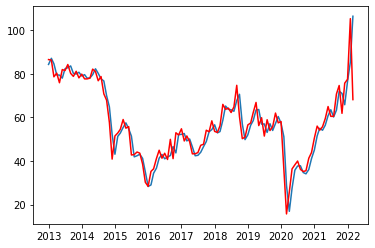

In [29]:
model = ARIMA(data['Prix en euros'], order = (1,0,1))
results = model.fit()
plt.plot(data['Prix en euros'])
plt.plot(results.fittedvalues, color='red')

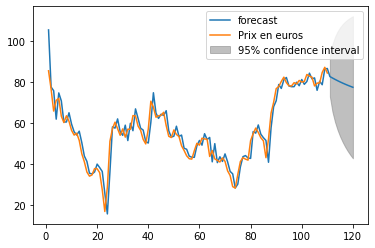

In [30]:
results.plot_predict(1,120);

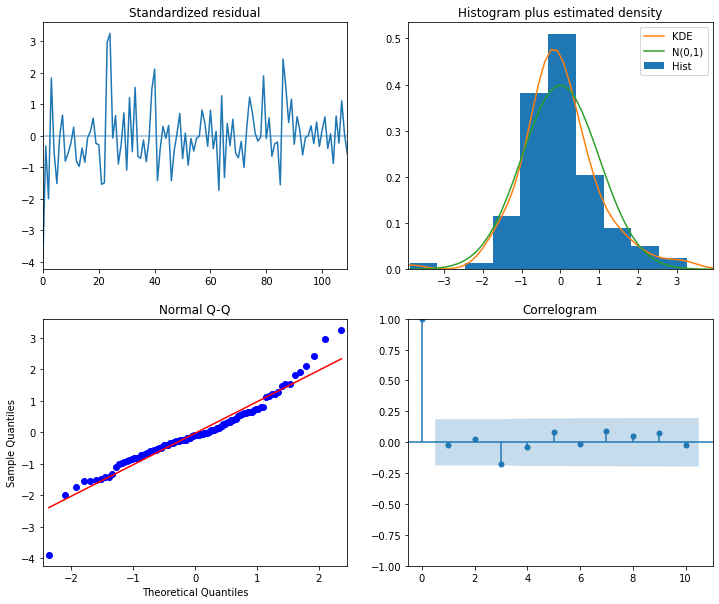

In [32]:
steps.plot_diagnostics(figsize=(12, 10))
plt.show()


In [43]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(steps.resid(),lags=[10], return_df=True)


,lb_stat,lb_pvalue
10,5.621739,0.845979


La p_value est de 0.845979 donc le modèle est pertinent pour la pédiction
